<a href="https://colab.research.google.com/github/antonellagambarte/vision-por-computadoras-II/blob/main/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook para baseline

In [ ]:
import gdown
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import random
import cv2
import numpy as np
import hashlib
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.optim as optim
import time
import torchsummary

In [ ]:
url = "https://drive.google.com/uc?id=1EAe3-k6Mj6UBd3uEA3gtotnSxtIIEkri"
output = "archivo.zip"

gdown.download(url, output, quiet=False, fuzzy=True)

destino = "datos_zip"
os.makedirs(destino, exist_ok=True)
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(destino)

print("Archivo extraído correctamente en :", destino)

Downloading...
From (original): https://drive.google.com/uc?id=1QQKRENeBHR_Vj6az52N5sOx6ouSNKsuk
From (redirected): https://drive.google.com/uc?id=1QQKRENeBHR_Vj6az52N5sOx6ouSNKsuk&confirm=t&uuid=51ffce5f-16c5-4b36-9a3c-2ce407bce5f8
To: /content/archivo.zip
100%|██████████| 2.19G/2.19G [00:19<00:00, 110MB/s]


Archivo extraído correctamente en : datos_zip


Valores para normalización y tamaño de imagen (Fuente: [Pytorch doc](https://docs.pytorch.org/vision/0.12/models.html))



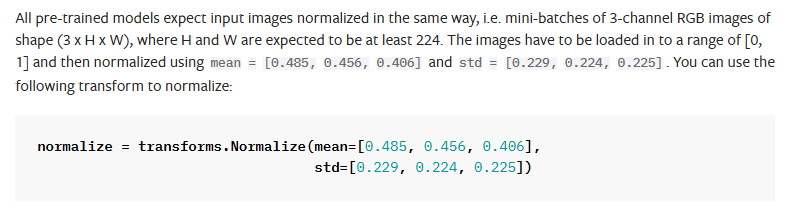

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225])
])

In [ ]:
data_dir = "datos_zip/plantvillage dataset/color"

full_dataset = datasets.ImageFolder(root=data_dir)

train_dataset, val_dataset = random_split(full_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)


train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

In [ ]:
# # PARA TRABAJAR CON PORCION DE DATASET

# data_dir = "datos_zip/plantvillage dataset/color"

# # Dataset completo con transform neutro (solo para poder hacer subset)
# full_dataset = datasets.ImageFolder(root=data_dir)

# # ------------ Crear subset reducido estratificado -----------------
# subset_indices = []
# reduction_factor = 0.1
# np.random.seed(42)

# for class_idx in range(len(full_dataset.classes)):
#     class_indices = [i for i, (_, label) in enumerate(full_dataset.samples) if label == class_idx]
#     n_samples = max(1, int(len(class_indices) * reduction_factor))
#     chosen = np.random.choice(class_indices, n_samples, replace=False)
#     subset_indices.extend(chosen)

# # ------------ Transformaciones -----------------
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

# val_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

# # ------------ Crear Subsets con transform aplicado -----------------
# train_size = int(0.8 * len(subset_indices))
# val_size = len(subset_indices) - train_size

# np.random.shuffle(subset_indices)  # mezclar índices
# train_indices = subset_indices[:train_size]
# val_indices = subset_indices[train_size:]

# # Crear datasets con transform correcto
# train_dataset = Subset(datasets.ImageFolder(root=data_dir, transform=train_transform), train_indices)
# val_dataset   = Subset(datasets.ImageFolder(root=data_dir, transform=val_transform), val_indices)


In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(models.list_models())

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'deeplabv3_mobilenet_v3_large', 'deeplabv3_resnet101', 'deeplabv3_resnet50', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'fasterrcnn_mobilenet_v3_large_320_fpn', 'fasterrcnn_mobilenet_v3_large_fpn', 'fasterrcnn_resnet50_fpn', 'fasterrcnn_resnet50_fpn_v2', 'fcn_resnet101', 'fcn_resnet50', 'fcos_resnet50_fpn', 'googlenet', 'inception_v3', 'keypointrcnn_resnet50_fpn', 'lraspp_mobilenet_v3_large', 'maskrcnn_resnet50_fpn', 'maskrcnn_resnet50_fpn_v2', 'maxvit_t', 'mc3_18', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mvit_v1_b', 'mvit_v2_s', 'quantized_googlenet', 'quantized_inception_v3', 'quantized_mobilenet_v2

Pesos disponibles para mobilenet v2 ([Link fuente](https://docs.pytorch.org/vision/main/models.html)):

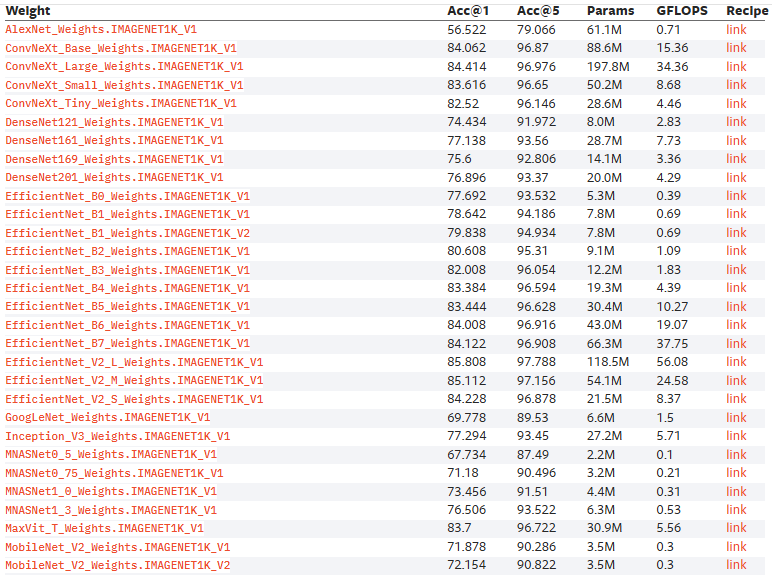

In [ ]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)


# Congelamos el feature extractor (model.features) para mantener los pesos aprendidos del modelo preentrenado en ImageNet.
# De este modo solo entrenamos la nueva capa clasificadora

for param in model.parameters():
    param.requires_grad = False



Sólo una capa lineal y dropout

In [ ]:
num_classes = 38
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, num_classes)
)


Uso de una función de pérdida estándar y el optimizador más básico

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

EPOCH = 10

for epoch in range(EPOCH):

    # TRAIN
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_accuracy = correct / total
    train_accs.append(train_accuracy)

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = correct / total
    val_accs.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f} | Train Acc={train_accuracy:.4f} | Val Loss={avg_val_loss:.4f} | Val Acc={val_accuracy:.4f}")



Epoch 1: Train Loss=0.9419 | Train Acc=0.8109 | Val Loss=0.3855 | Val Acc=0.9255
Epoch 2: Train Loss=0.3713 | Train Acc=0.9222 | Val Loss=0.2566 | Val Acc=0.9473
Epoch 3: Train Loss=0.2849 | Train Acc=0.9344 | Val Loss=0.2079 | Val Acc=0.9552
Epoch 4: Train Loss=0.2429 | Train Acc=0.9421 | Val Loss=0.1786 | Val Acc=0.9599
Epoch 5: Train Loss=0.2169 | Train Acc=0.9466 | Val Loss=0.1627 | Val Acc=0.9623
Epoch 6: Train Loss=0.1995 | Train Acc=0.9499 | Val Loss=0.1552 | Val Acc=0.9620
Epoch 7: Train Loss=0.1860 | Train Acc=0.9521 | Val Loss=0.1444 | Val Acc=0.9649
Epoch 8: Train Loss=0.1752 | Train Acc=0.9541 | Val Loss=0.1373 | Val Acc=0.9671
Epoch 9: Train Loss=0.1656 | Train Acc=0.9573 | Val Loss=0.1293 | Val Acc=0.9672
Epoch 10: Train Loss=0.1622 | Train Acc=0.9564 | Val Loss=0.1273 | Val Acc=0.9674


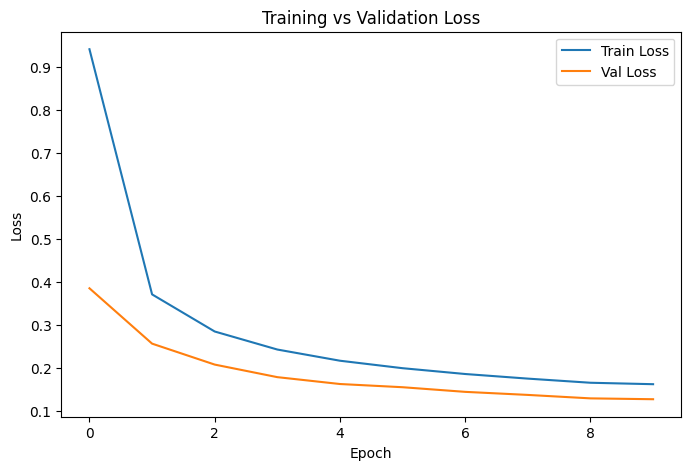

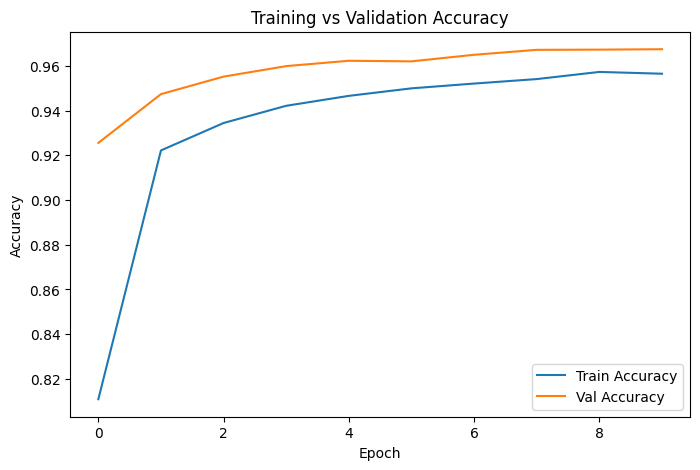

In [ ]:
import matplotlib.pyplot as plt

# ---- GRAFICO DE LOSS ----
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# ---- GRAFICO DE ACCURACY ----
plt.figure(figsize=(8,5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

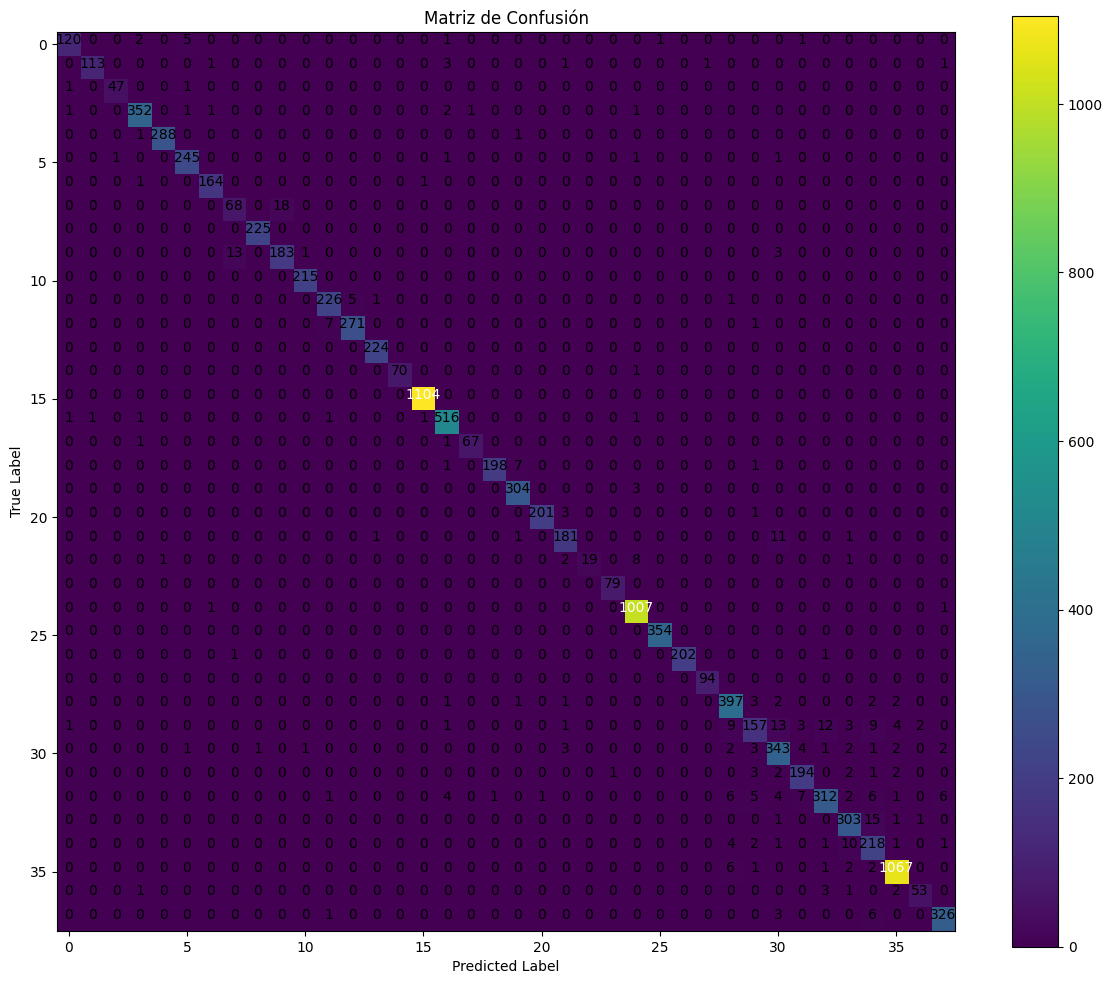

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 1) Obtener predicciones del modelo en el loader de validación/test
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 2) Crear matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# 3) Graficar
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de Confusión")
plt.colorbar()

# Opcional: mostrar números
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


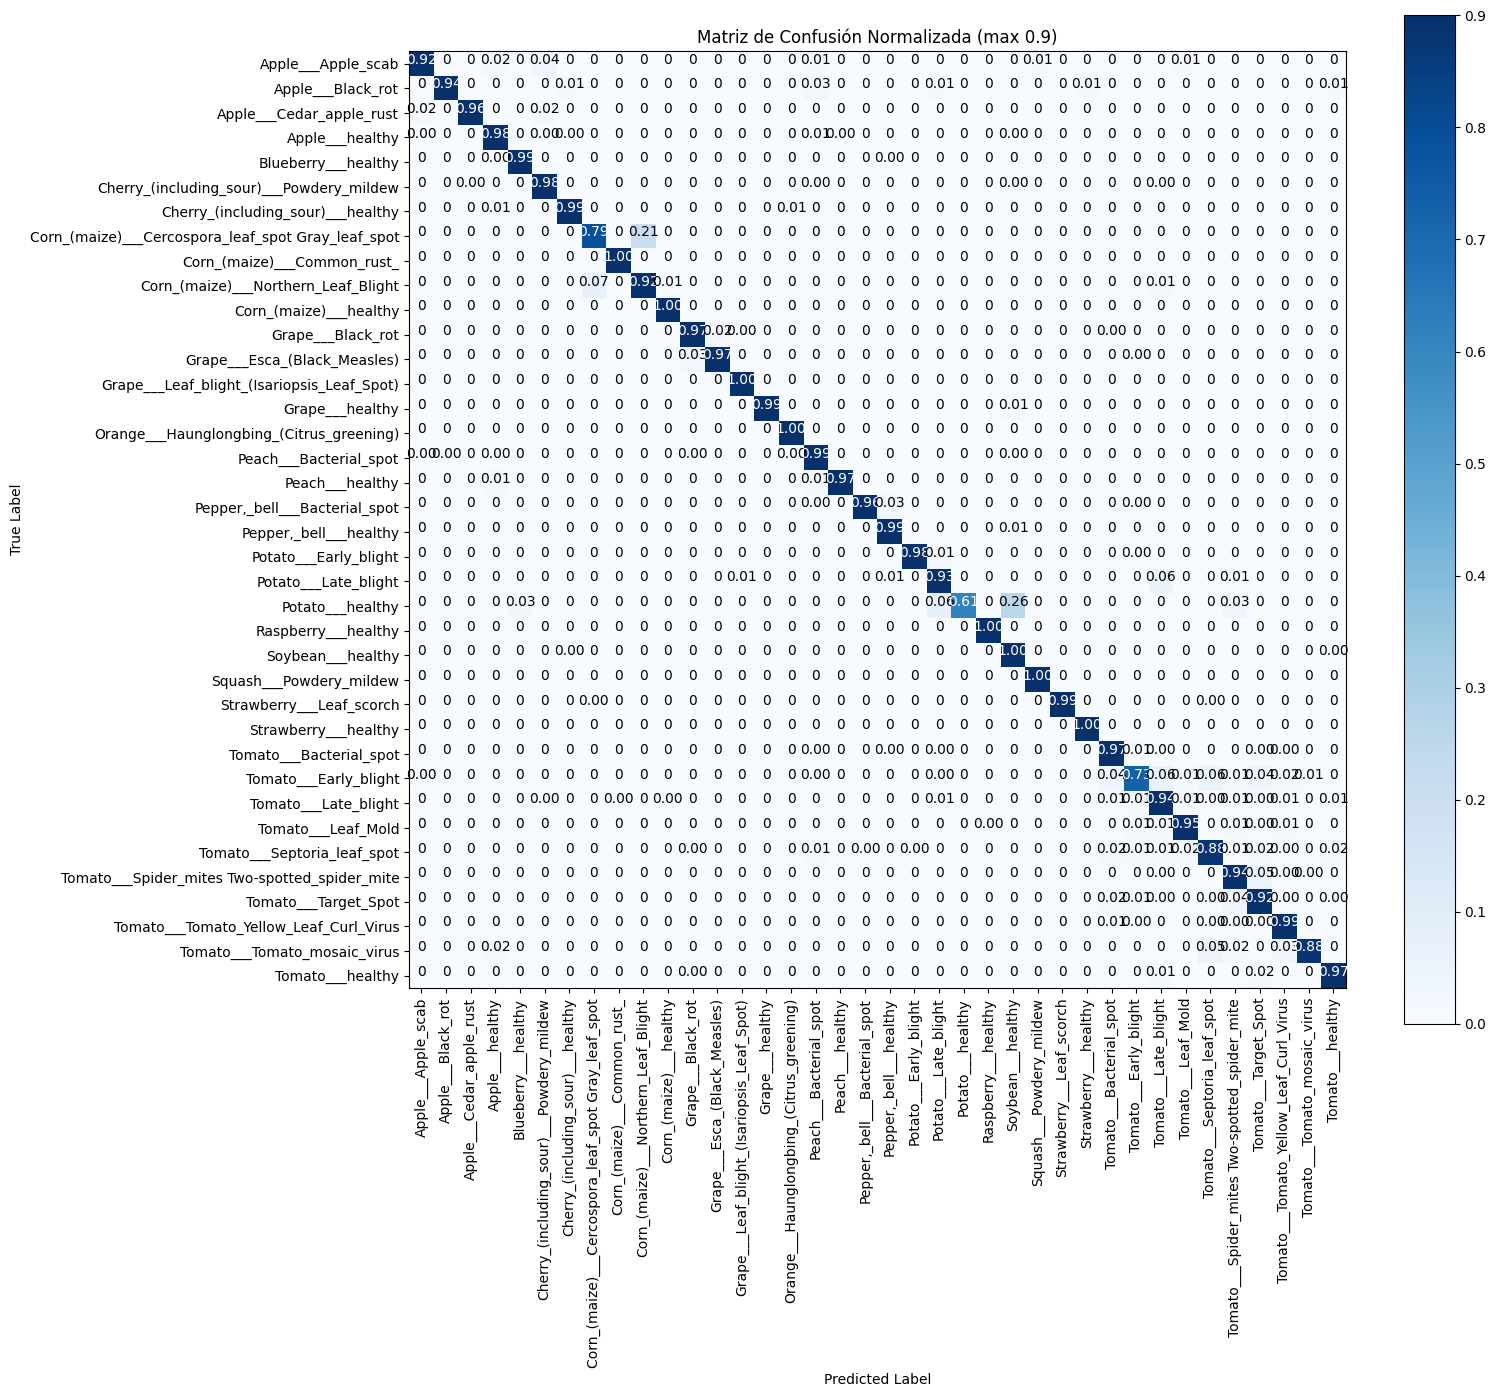

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Obtener predicciones
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Crear y normalizar la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Graficar
plt.figure(figsize=(16, 14))
im = plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=0.9)
plt.title("Matriz de Confusión Normalizada (max 0.9)")
plt.colorbar(im)

# Etiquetas de clases
classes = full_dataset.classes
plt.xticks(np.arange(len(classes)), classes, rotation=90)
plt.yticks(np.arange(len(classes)), classes)

# Mostrar números, con "0" si es cero
thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        val = cm_normalized[i, j]
        text = "0" if val == 0 else f"{val:.2f}"
        plt.text(j, i, text,
                 horizontalalignment="center",
                 color="white" if val > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

